In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('YouTube_EDA').getOrCreate()

## USA

In [3]:
# Load the data
import os
current_path = os.getcwd()
full_path = f'file://{current_path}/GB_youtube_trending_data_clean.csv'
df = spark.read.csv(full_path, inferSchema = True, header = True)
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- _c15: string (nullable = true)



In [4]:
# get rid of last empty column that spark inferschema made
df = df.drop("_c15")
df.show(5)

+-----------+--------------------+-------------------+--------------------+-------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|       trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|
+-----------+--------------------+-------------------+--------------------+-------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|J78aPJ3VyNs|I left youtube fo...|2020-08-11 12:34:06|UCYzPXprvl5Y-Sf0g...|jacksepticeye|        24|2020-08-12T00:00:00Z|jacksepticeye|fun...|   2038853|353790|    2628|        40228|https://i.ytimg.c...|            false|           false|
|9nidKH8cM38|TAXI CAB SLAYER K...|2020-0

In [5]:
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# clean data, drop bad records
print('Rows with no views: ' + str(df.filter(df['view_count'] == 0).count()))
print('Total rows: ' + str(df.count()))

Rows with no views: 94
Total rows: 268805


In [7]:
# Filter out rows with view_count = 0
df = df.filter(F.col("view_count") != 0)
print('Updated rows: ' + str(df.count()))

Updated rows: 268683


In [8]:
df.groupBy("comments_disabled").count().show()

# Filter out rows with no comments
df = df.filter(F.col("comments_disabled") != 'true')

+-----------------+------+
|comments_disabled| count|
+-----------------+------+
|             true|  4771|
|            false|263912|
+-----------------+------+



Total videos: 263912
Distinct video IDs: 46703
+-----------+-----+
|   video_id|count|
+-----------+-----+
|rDG-6Ue_Qbw|   17|
|x9XHMK3nWr4|   17|
|w6OJl42Ntko|   16|
|M9SVC_lIpss|   16|
|PbdyXIaBK9A|   16|
|QZM_sB5uVEs|   16|
|kLMZPlIufA0|   16|
|_L0QyGE4nJM|   16|
|udtLKxVZc5Y|   16|
|EOqw86OGIB0|   16|
+-----------+-----+
only showing top 10 rows



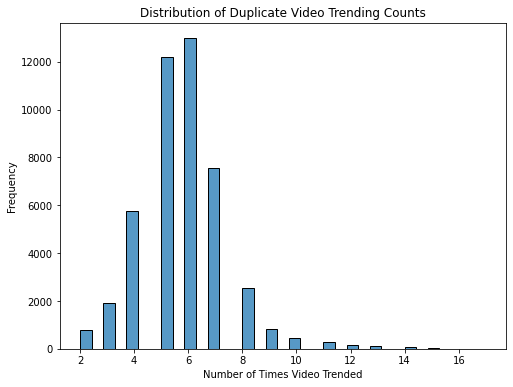

In [9]:
# eda for video ids, getting videos that trended most often too 
# Count total rows and distinct video IDs
total_videos = df.count()
distinct_videos = df.select("video_id").distinct().count()
print("Total videos:", total_videos)
print("Distinct video IDs:", distinct_videos)

# find video_ids that occur more than once (duplicate entries)
duplicates = df.groupBy("video_id").count().filter("count > 1").orderBy("count", ascending = False)
duplicates.show(10)

duplicates_pd = duplicates.toPandas()

plt.figure(figsize=(8,6))
sns.histplot(duplicates_pd['count'], bins=35)
plt.title("Distribution of Duplicate Video Trending Counts")
plt.xlabel("Number of Times Video Trended")
plt.ylabel("Frequency")
plt.show()

+------------------------------------------------------------+------------+----------+
|title                                                       |title_length|word_count|
+------------------------------------------------------------+------------+----------+
|I left youtube for a month and THIS is what happened.       |53          |11        |
|TAXI CAB SLAYER KILLS 'TO KNOW HOW IT FEELS'                |44          |9         |
|Apex Legends | Stories from the Outlands – “The Endorsement”|60          |10        |
|Nines - Clout (Official Video)                              |30          |5         |
|i don't know what im doing anymore                          |34          |7         |
+------------------------------------------------------------+------------+----------+
only showing top 5 rows

+-------+------------------+------------------+
|summary|      title_length|        word_count|
+-------+------------------+------------------+
|  count|            263912|            263912|


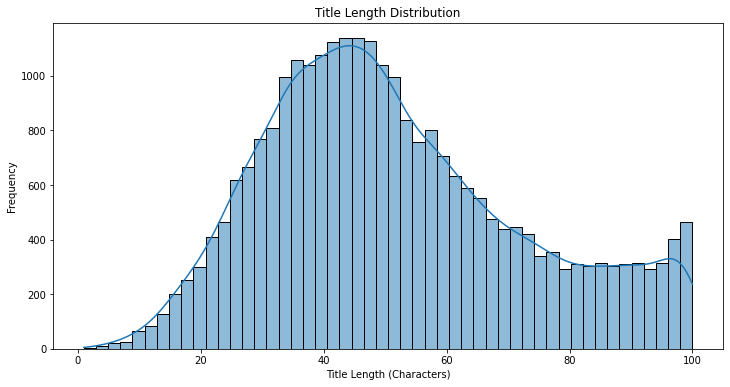

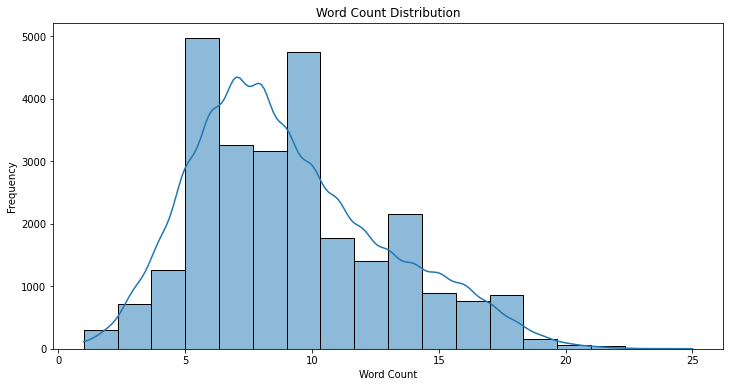

In [10]:
# adding title statistics and seeing statistics 
# Create a column for the length of each title (number of characters)
df = df.withColumn("title_length", F.length("title"))

# Create a column for the word count (splitting on whitespace)
df = df.withColumn("word_count", F.size(F.split("title", " ")))

# View sample titles with computed lengths and word counts
df.select("title", "title_length", "word_count").show(5, truncate=False)

# Get summary statistics on title length and word count
df.select("title_length", "word_count").describe().show()

# take sample
sample_titles = df.select("title_length", "word_count").sample(fraction=0.10, seed=42).toPandas()

# Plot 1: Title Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["title_length"], bins=50, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Word Count Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["word_count"], bins=18, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [11]:
# looking at publishing and time features

# Extract year, month, and day of week from publishedAt
df = df.withColumn("publish_year", F.year("publishedAt")).withColumn("publish_month", F.month("publishedAt")).withColumn("publish_dayofweek", F.dayofweek("publishedAt")).withColumn("publish_hour", F.hour("publishedAt"))

# Show a sample of the new time-related columns
df.select("publishedAt", "publish_year", "publish_month", "publish_dayofweek", "publish_hour").show(5)

# Group by publish year to see counts per year
df.groupBy("publish_year").count().orderBy("publish_year").show()


+-------------------+------------+-------------+-----------------+------------+
|        publishedAt|publish_year|publish_month|publish_dayofweek|publish_hour|
+-------------------+------------+-------------+-----------------+------------+
|2020-08-11 12:34:06|        2020|            8|                3|          12|
|2020-08-11 16:00:45|        2020|            8|                3|          16|
|2020-08-11 13:00:10|        2020|            8|                3|          13|
|2020-08-10 14:30:28|        2020|            8|                2|          14|
|2020-08-11 16:24:34|        2020|            8|                3|          16|
+-------------------+------------+-------------+-----------------+------------+
only showing top 5 rows

+------------+-----+
|publish_year|count|
+------------+-----+
|        2020|27669|
|        2021|72797|
|        2022|71752|
|        2023|71614|
|        2024|20080|
+------------+-----+



+-------------+-----+
|publish_month|count|
+-------------+-----+
|            1|23774|
|            2|22724|
|            3|24843|
|            4|19348|
|            5|18342|
|            6|19078|
|            7|18155|
|            8|23004|
|            9|23256|
|           10|24232|
|           11|22934|
|           12|24222|
+-------------+-----+



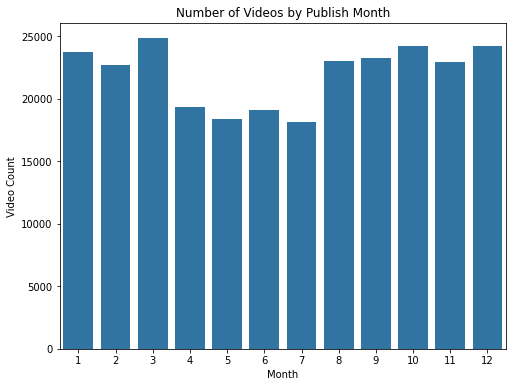

In [12]:
# Aggregate count by month of publication
monthly_counts = df.groupBy(F.month("publishedAt").alias("publish_month")).count().orderBy("publish_month")
monthly_counts.show()

# Convert to Pandas for plotting
monthly_pd = monthly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_month", y="count", data=monthly_pd)
plt.title("Number of Videos by Publish Month")
plt.xlabel("Month")
plt.ylabel("Video Count")
plt.show()


+-----------+-----+
|publish_day|count|
+-----------+-----+
|          1|42174|
|          2|36003|
|          3|39141|
|          4|38907|
|          5|37338|
|          6|35061|
|          7|35288|
+-----------+-----+



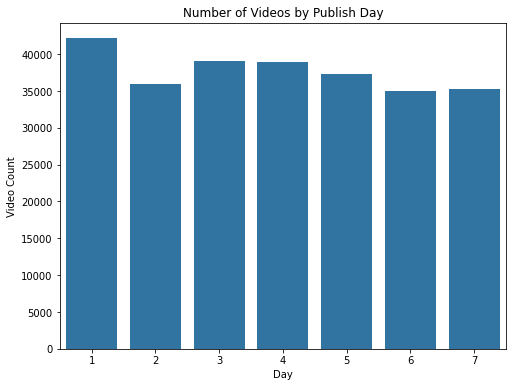

In [13]:
# Aggregate count by month of publication
weekly_counts = df.groupBy(F.dayofweek("publishedAt").alias("publish_day")).count().orderBy("publish_day")
weekly_counts.show()

# Convert to Pandas for plotting
weekly_pd = weekly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_day", y="count", data=weekly_pd)
plt.title("Number of Videos by Publish Day")
plt.xlabel("Day")
plt.ylabel("Video Count")
plt.show()


+------------+-----+
|publish_hour|count|
+------------+-----+
|           0|10057|
|           1| 3568|
|           2| 2960|
|           3| 3846|
|           4| 4893|
|           5| 6886|
|           6| 4402|
|           7| 4936|
|           8| 7457|
|           9|11976|
|          10|15669|
|          11|22377|
|          12|28718|
|          13|27889|
|          14|24136|
|          15|20271|
|          16|14688|
|          17|13896|
|          18| 9866|
|          19| 7773|
+------------+-----+
only showing top 20 rows



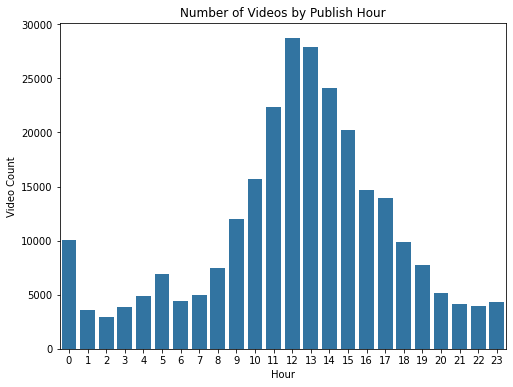

In [14]:
# Aggregate count by month of publication
hourly_counts = df.groupBy(F.hour("publishedAt").alias("publish_hour")).count().orderBy("publish_hour")
hourly_counts.show()

# Convert to Pandas for plotting
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_hour", y="count", data=hourly_pd)
plt.title("Number of Videos by Publish Hour")
plt.xlabel("Hour")
plt.ylabel("Video Count")
plt.show()

In [15]:
# Count how many trending videos each channel has
df.groupBy("channelId", "channelTitle").count().orderBy("count", ascending=False).show(10)

+--------------------+--------------------+-----+
|           channelId|        channelTitle|count|
+--------------------+--------------------+-----+
|UCMmVPVb0BwSIOWVe...|    The United Stand| 2742|
|UC4i_9WvfPRTuRWEa...|            BT Sport| 1596|
|UCNAf1k0yIjyGu3k9...| Sky Sports Football| 1591|
|UCh5mLn90vUaB1PbR...|         MoreSidemen| 1321|
|UCB_qr75-ydFVKSF9...|           FORMULA 1| 1303|
|UCNAf1k0yIjyGu3k9...|Sky Sports Premie...| 1292|
|UCJ5v_MCY6GNUBTO8...|                 WWE| 1038|
|UCDogdKl7t7NHzQ95...|             Sidemen|  958|
|UCX6OQ3DkcsbYNE6H...|             MrBeast|  652|
|UCurvRE5fGcdUgCYW...|         DAZN Boxing|  618|
+--------------------+--------------------+-----+
only showing top 10 rows



In [16]:
# mapping categoryid to its value through joining json file
json_path = f'file://{os.getcwd()}/GB_category_id.json'


categories_df = spark.read.option("multiLine", "true").json(json_path)
categories_df = categories_df.select(F.explode("items").alias("item"))
categories_df = categories_df.select(
    F.col("item.id").alias("categoryId"),
    F.col("item.snippet.title").alias("categoryTitle")
)

# Cast categoryId to integer so it matches your main DataFrame
categories_df = categories_df.withColumn("categoryId", F.col("categoryId").cast("integer"))

# Show the categories for verification
categories_df.show(truncate=False)


+----------+--------------------+
|categoryId|categoryTitle       |
+----------+--------------------+
|1         |Film & Animation    |
|2         |Autos & Vehicles    |
|10        |Music               |
|15        |Pets & Animals      |
|17        |Sports              |
|18        |Short Movies        |
|19        |Travel & Events     |
|20        |Gaming              |
|21        |Videoblogging       |
|22        |People & Blogs      |
|23        |Comedy              |
|24        |Entertainment       |
|25        |News & Politics     |
|26        |Howto & Style       |
|27        |Education           |
|28        |Science & Technology|
|30        |Movies              |
|31        |Anime/Animation     |
|32        |Action/Adventure    |
|33        |Classics            |
+----------+--------------------+
only showing top 20 rows



+--------------------+-----+
|categoryTitle       |count|
+--------------------+-----+
|Entertainment       |56287|
|Sports              |48399|
|Gaming              |45691|
|Music               |33204|
|People & Blogs      |24256|
|Comedy              |12079|
|Science & Technology|7986 |
|Film & Animation    |7768 |
|Autos & Vehicles    |6667 |
|Education           |6574 |
|Howto & Style       |5748 |
|News & Politics     |5439 |
|Travel & Events     |2646 |
|Pets & Animals      |1069 |
|NULL                |99   |
+--------------------+-----+



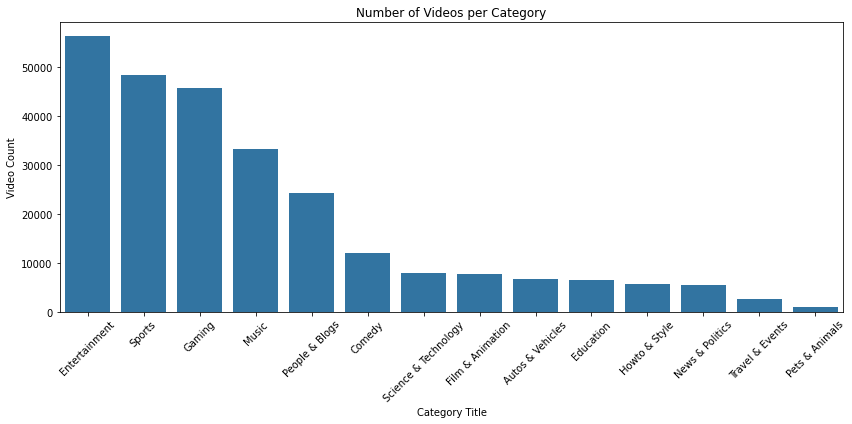

In [17]:
# Join the main DataFrame 'df' with the categories DataFrame
df_with_categories = df.join(categories_df, on="categoryId", how="left")

# Group by categoryTitle and count videos
category_counts = df_with_categories.groupBy("categoryTitle").count().orderBy("count", ascending=False)
category_counts.show(truncate=False)

# Convert to Pandas for visualization
category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="categoryTitle", y="count", data=category_counts_pd)
plt.title("Number of Videos per Category")
plt.xlabel("Category Title")
plt.ylabel("Video Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

75th percentile of view counts: 1868636.0


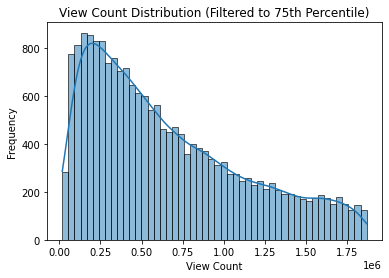

In [18]:
# Convert a sample to Pandas for a histogram
sample_views = df.select("view_count").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: the 75th percentile of view counts
threshold = sample_views["view_count"].quantile(0.75)
print("75th percentile of view counts:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_views = sample_views[sample_views["view_count"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_sample_views["view_count"], bins=50, kde=True)
plt.title("View Count Distribution (Filtered to 75th Percentile)")
plt.xlabel("View Count")
plt.ylabel("Frequency")
plt.show()


+-------+------------------+
|summary|             likes|
+-------+------------------+
|  count|            263912|
|   mean|109520.99947330929|
| stddev|349341.72935648053|
|    min|                 0|
|    max|          15246514|
+-------+------------------+

+------+----------+-----------+
| likes|view_count|likes_ratio|
+------+----------+-----------+
|353790|   2038853|       0.17|
| 16423|    236830|       0.07|
|146739|   2381688|       0.06|
| 37567|    613785|       0.06|
| 87113|    940036|       0.09|
+------+----------+-----------+
only showing top 5 rows



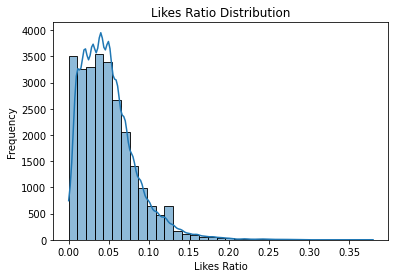

In [19]:
# Summary statistics for likes
df.select("likes").describe().show()

# Create a ratio column to see likes per view
df = df.withColumn("likes_ratio", F.round(F.col("likes") / F.col("view_count"), 2))
df.select("likes", "view_count", "likes_ratio").show(5)

# Take a 10% sample of the data for visualization
sample_likes_ratio = df.select("likes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_likes_ratio["likes_ratio"], bins=35, kde=True)
plt.title("Likes Ratio Distribution")
plt.xlabel("Likes Ratio")
plt.ylabel("Frequency")
plt.show()

75th percentile of view likes: 89211.0


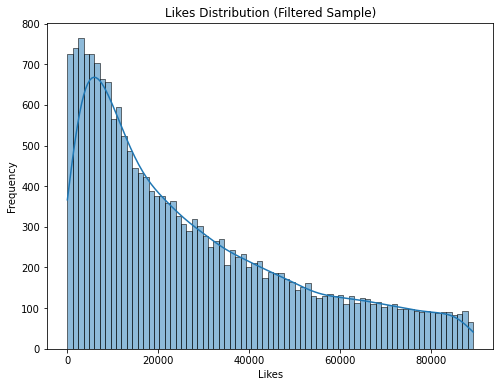

In [20]:
# Get a sample for visualization
sample_likes = df.select("likes").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_likes["likes"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_likes = sample_likes[sample_likes["likes"] <= threshold]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_sample_likes["likes"], bins=75, kde=True)
plt.title("Likes Distribution (Filtered Sample)")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

+-------+-----------------+
|summary|         dislikes|
+-------+-----------------+
|  count|           263912|
|   mean| 970.414926187517|
| stddev|7320.229554966143|
|    min|                0|
|    max|           865075|
+-------+-----------------+

+--------+----------+--------------+
|dislikes|view_count|dislikes_ratio|
+--------+----------+--------------+
|    2628|   2038853|    0.00128896|
|     209|    236830|   8.824895E-4|
|    2794|   2381688|  0.0011731176|
|     669|    613785|  0.0010899582|
|    1860|    940036|  0.0019786476|
+--------+----------+--------------+
only showing top 5 rows

75th percentile of view likes: 0.0004915025


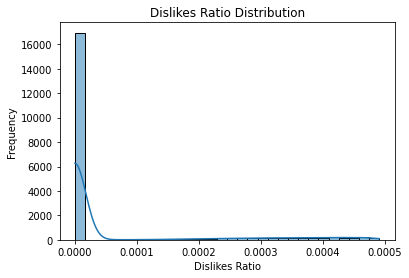

In [21]:
# Summary statistics for dislikes
df.select("dislikes").describe().show()

# Create a ratio column to see likes per view (watch out for division by zero)
df = df.withColumn("dislikes_ratio", F.round(F.col("dislikes") / F.col("view_count"), 10))
df.select("dislikes", "view_count", "dislikes_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_dislikes_ratio = df.select("dislikes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_dislikes_ratio["dislikes_ratio"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_dislikes_ratio = sample_dislikes_ratio[sample_dislikes_ratio["dislikes_ratio"] <= threshold]

# Plot the histogram for the likes_ratio distribution
sns.histplot(filtered_sample_dislikes_ratio["dislikes_ratio"], bins=30, kde=True)
plt.title("Dislikes Ratio Distribution")
plt.xlabel("Dislikes Ratio")
plt.ylabel("Frequency")
plt.show()


+-------+-----------------+
|summary|    comment_count|
+-------+-----------------+
|  count|           263912|
|   mean|8129.999386159023|
| stddev|60069.97248450681|
|    min|                0|
|    max|          5987770|
+-------+-----------------+

+-------------+----------+--------------------+
|comment_count|view_count|      comments_ratio|
+-------------+----------+--------------------+
|        40228|   2038853|0.019730701526789816|
|         1642|    236830|0.006933243254655238|
|        16549|   2381688|0.006948433212074797|
|         2101|    613785|0.003423022719681...|
|         7052|    940036|0.007501840355050232|
+-------------+----------+--------------------+
only showing top 5 rows

75th percentile of comments ratio: 0.004683298763155873


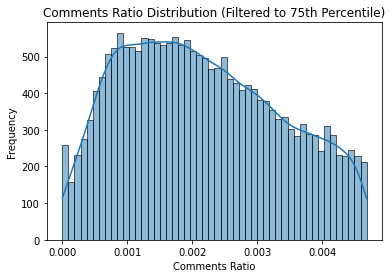

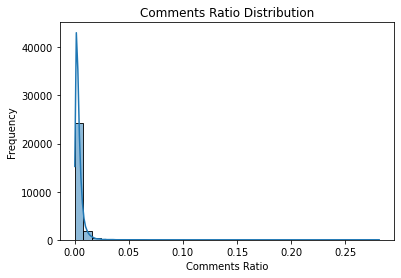

In [22]:
# Summary statistics for comment_count
df.select("comment_count").describe().show()

# Create a ratio column for comments per view
df = df.withColumn("comments_ratio", F.col("comment_count")/F.col("view_count"))
df.select("comment_count", "view_count", "comments_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_comments_ratio = df.select("comments_ratio").sample(fraction=0.10, seed=42).toPandas()

threshold = sample_comments_ratio["comments_ratio"].quantile(0.75)
print("75th percentile of comments ratio:", threshold)

# Filter the data to include only view counts below the threshold
filtered_comments_ratio = sample_comments_ratio[sample_comments_ratio["comments_ratio"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_comments_ratio["comments_ratio"], bins=50, kde=True)
plt.title("Comments Ratio Distribution (Filtered to 75th Percentile)")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_comments_ratio["comments_ratio"], bins=35, kde=True)
plt.title("Comments Ratio Distribution")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


In [23]:
df.show(2)

+-----------+--------------------+-------------------+--------------------+-------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+------------+----------+------------+-------------+-----------------+------------+-----------+--------------+--------------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|       trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|title_length|word_count|publish_year|publish_month|publish_dayofweek|publish_hour|likes_ratio|dislikes_ratio|      comments_ratio|
+-----------+--------------------+-------------------+--------------------+-------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+------------+--------

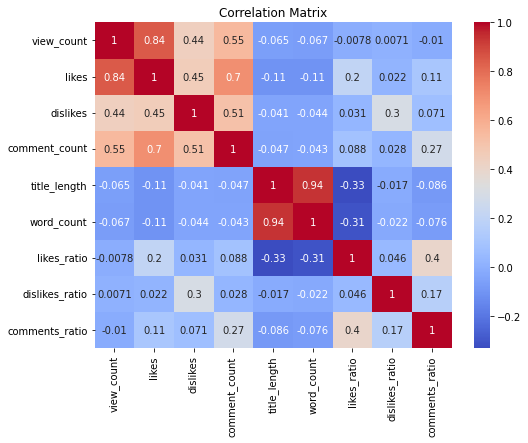

In [24]:
df_numeric = df.select(["view_count", "likes", "dislikes", "comment_count", "title_length", "word_count", "likes_ratio", "dislikes_ratio", "comments_ratio"])

df_numeric_pd = df_numeric.sample(fraction=0.1, seed=42).toPandas()

# Compute the correlation matrix using Pandas
corr_matrix = df_numeric_pd.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

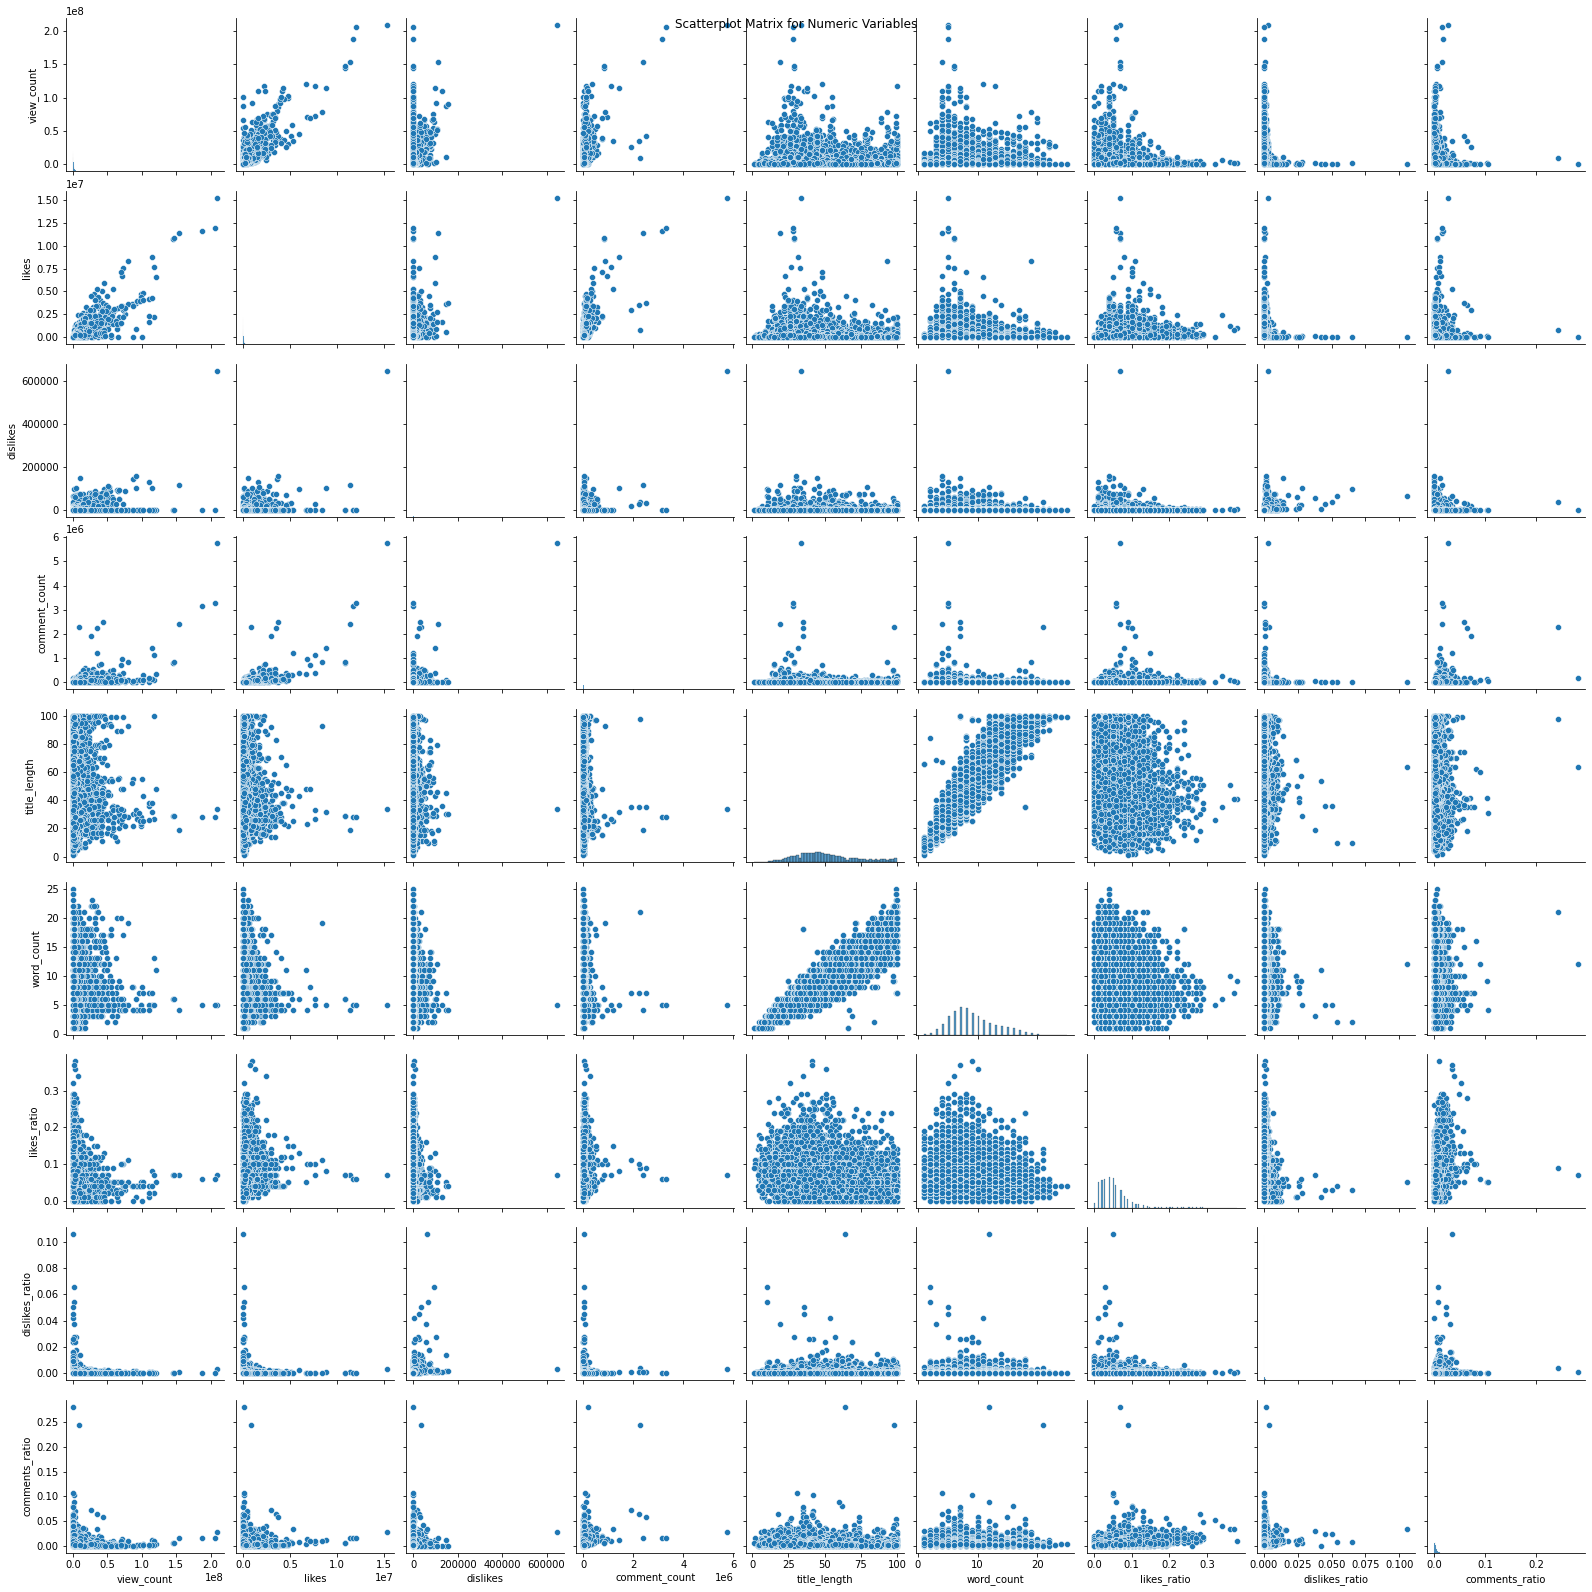

In [25]:
sns.pairplot(df_numeric_pd)
plt.suptitle("Scatterplot Matrix for Numeric Variables")
plt.show()

## Great Britain

## United States